In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import shap

from treemind.algorithm import Explainer

from examples.examples_plot import (
    plot_line_chart,
    plot_scatter_chart,
    interaction_scatter_plot,
    feature_plot,
)

In [2]:
n_samples = 12000

np.random.seed(42)  # Setting a random seed for reproducibility

# Base features - karmaşık dağılımlar kullanabiliriz
feature_0 = np.random.gamma(shape=2, scale=2, size=n_samples)  # Gamma distribution
feature_1 = np.random.beta(2, 5, size=n_samples) * 10  # Beta distribution scaled
feature_2 = np.random.exponential(scale=1.5, size=n_samples)  # Exponential
feature_3 = np.random.chisquare(df=3, size=n_samples)  # Chi-square
feature_4 = np.random.weibull(1.5, size=n_samples)  # Weibull
feature_5 = np.random.normal(loc=2, scale=1.5, size=n_samples)  # Normal
feature_6 = np.random.uniform(low=-5, high=5, size=n_samples)  # Uniform
feature_7 = np.random.laplace(loc=0, scale=2, size=n_samples)  # Laplace

# Yorumlanabilir transformasyonlar
transformed_0 = 1 / (1 + np.exp(-feature_0 / 2))  # Sigmoid - smooth transition
transformed_1 = np.where(
    feature_1 > 5, 0.8 * feature_1, 0.3 * feature_1
)  # Piecewise linear
transformed_2 = np.minimum(feature_2**2 / 10, 4)  # Quadratic with ceiling
transformed_3 = np.sin(feature_3 / 2) * np.exp(-feature_3 / 10)  # Damped oscillation
transformed_4 = np.tanh(feature_4)  # Smooth bounded function
transformed_5 = np.where(
    feature_5 > 2, 2 + 0.2 * (feature_5 - 2), feature_5
)  # Linear with soft threshold
transformed_6 = 0.5 * feature_6 + 0.1 * feature_6**2  # Mild quadratic trend
transformed_7 = np.clip(feature_7, -2, 2)  # Clipped linear

# Binary interactions - daha basit ve yorumlanabilir
interaction_0_1 = transformed_0 * transformed_1  # Simple multiplication
interaction_2_3 = np.maximum(transformed_2, transformed_3)  # Maximum value
interaction_4_5 = (transformed_4 + transformed_5) / 2  # Average
interaction_6_7 = transformed_6 * np.sign(transformed_7)  # Sign-based scaling

# Target variable - daha dengeli ağırlıklar
target = target = (
    0.4 * transformed_0
    - 0.6 * transformed_1
    + 0.3 * transformed_2
    + 0.5 * transformed_3
    - 0.4 * transformed_4
    + 0.7 * transformed_5
    - 0.3 * transformed_6
    + 0.5 * transformed_7
    + 0.6 * interaction_0_1
    - 0.5 * interaction_2_3
    + 0.4 * interaction_4_5
    - 0.3 * interaction_6_7
    + np.random.normal(loc=0, scale=0.2, size=n_samples)  # Biraz daha noise ekledim
)

# Daha az ve daha kontrollü outlier
outlier_idx = np.random.choice(
    n_samples, size=int(n_samples * 0.005), replace=False
)  # %0.5 outlier
target[outlier_idx] += np.random.normal(loc=0, scale=3, size=len(outlier_idx))

# Create DataFrame
df = pd.DataFrame(
    {
        "feature_0": feature_0,
        "feature_1": feature_1,
        "feature_2": feature_2,
        "feature_3": feature_3,
        "feature_4": feature_4,
        "feature_5": feature_5,
        "feature_6": feature_6,
        "feature_7": feature_7,
        "target": target,
    }
)

# Split the data
X = df.drop("target", axis=1).values
y = df["target"].values

In [3]:
# Train a LightGBM model
reg = LGBMRegressor(verbose=-1, n_estimators=500, num_leaves=75, learning_rate=0.02)
reg.fit(X, y)  #

# Use treemind's Explainer to analyze the trained model
explainer = Explainer()
explainer(reg)

# Use shap's TreeExplainer to analyze the trained model
shap_explainer = shap.TreeExplainer(reg)
shap_values = shap_explainer(X)
shap_interaction_values = shap_explainer.shap_interaction_values(X)

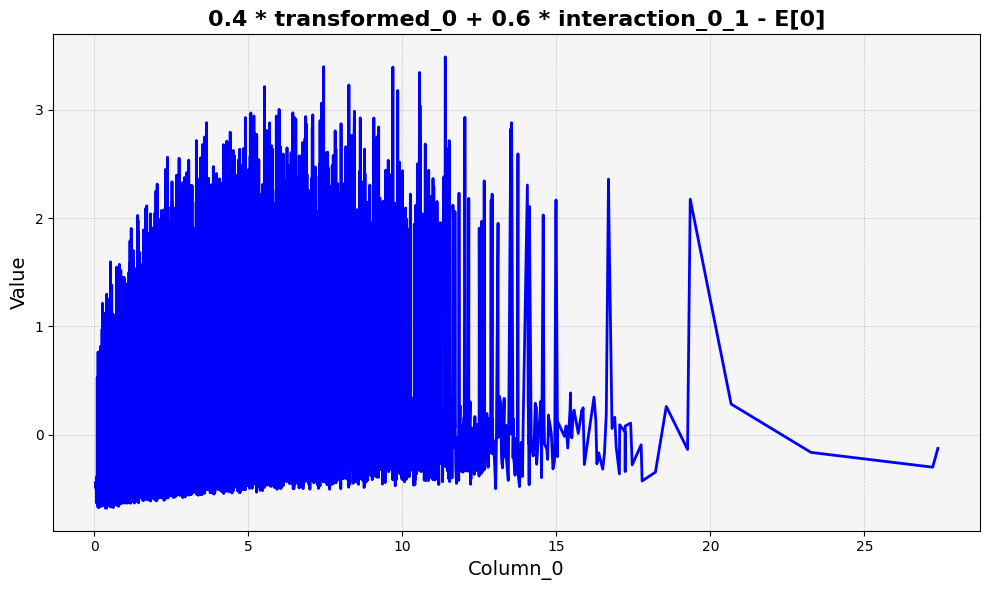

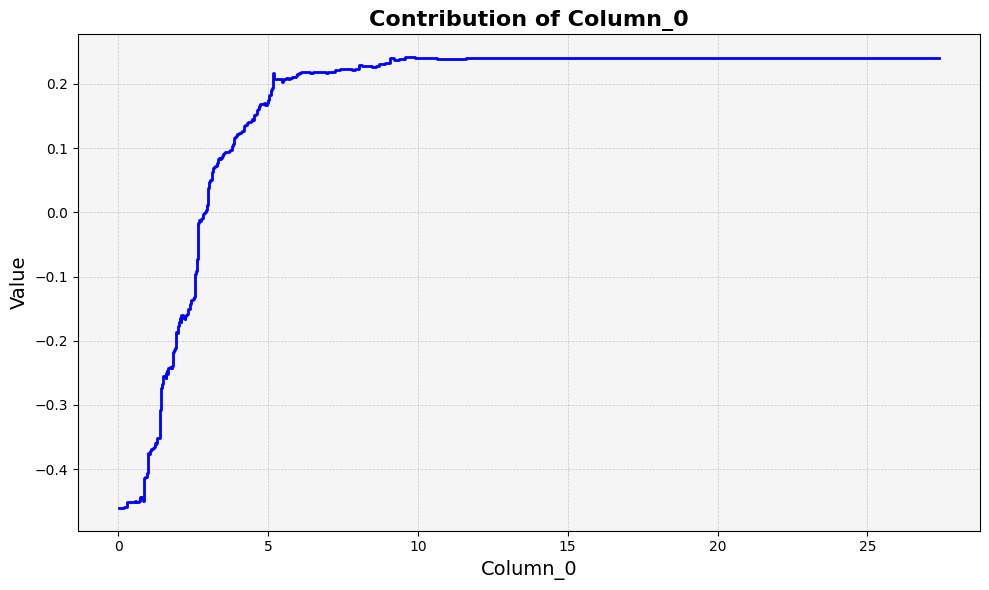

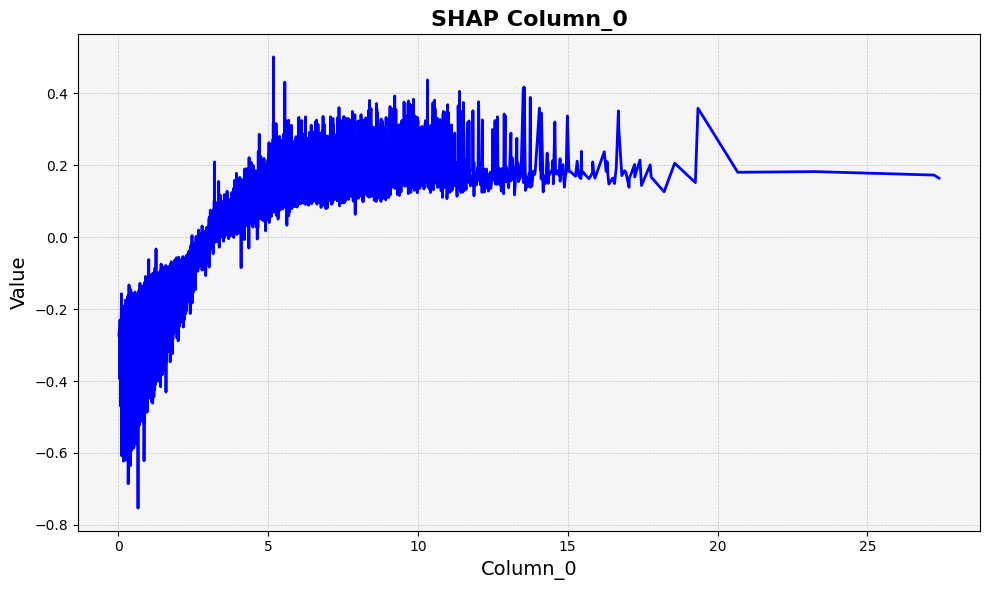

In [4]:
# Feature 0 Analysis
feature_df_0 = explainer.analyze_feature(0)
plot_line_chart(
    x=feature_0,
    y=0.4 * transformed_0
    + 0.6 * interaction_0_1
    - np.mean(0.4 * transformed_0 + 0.6 * interaction_0_1),
    x_label="Column_0",
    y_label="Value",
    title="0.4 * transformed_0 + 0.6 * interaction_0_1 - E[0]",
)
feature_plot(
    feature_df_0, show_min_max=False, col_min=X[:, 0].min(), col_max=X[:, 0].max()
)
plot_line_chart(
    x=feature_0,
    y=shap_values.values[:, 0],
    x_label="Column_0",
    y_label="Value",
    title="SHAP Column_0",
)

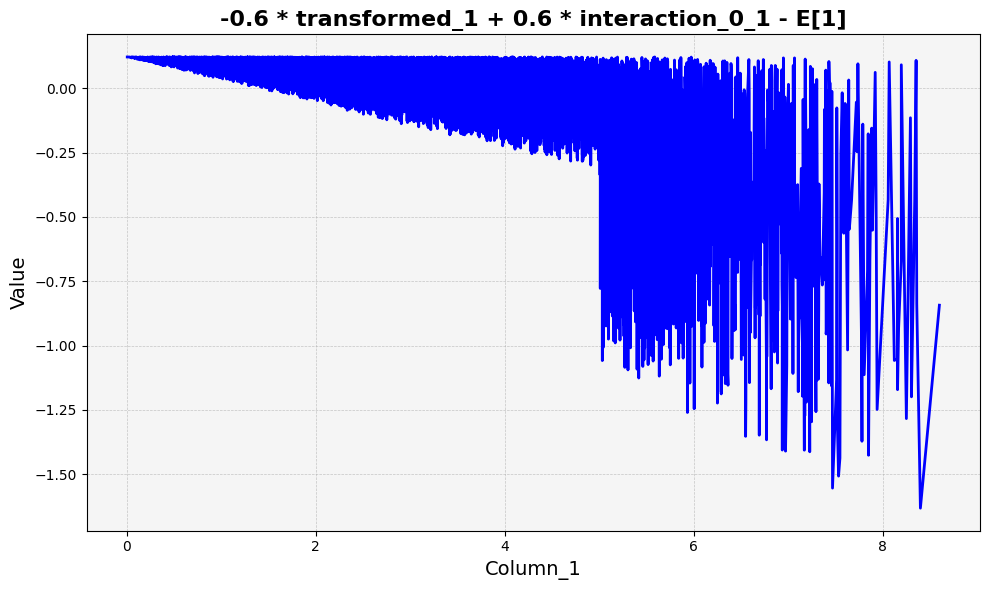

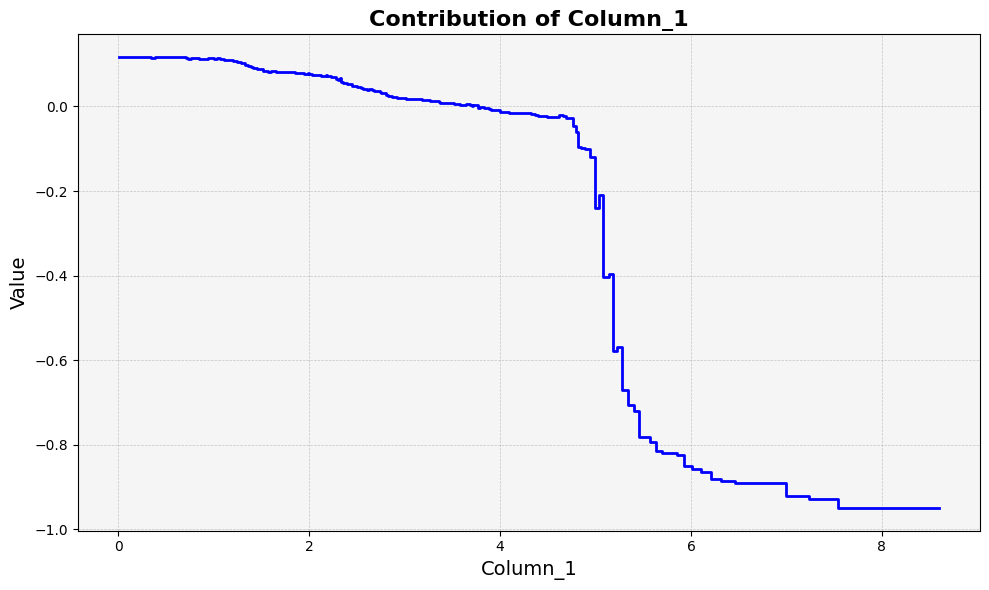

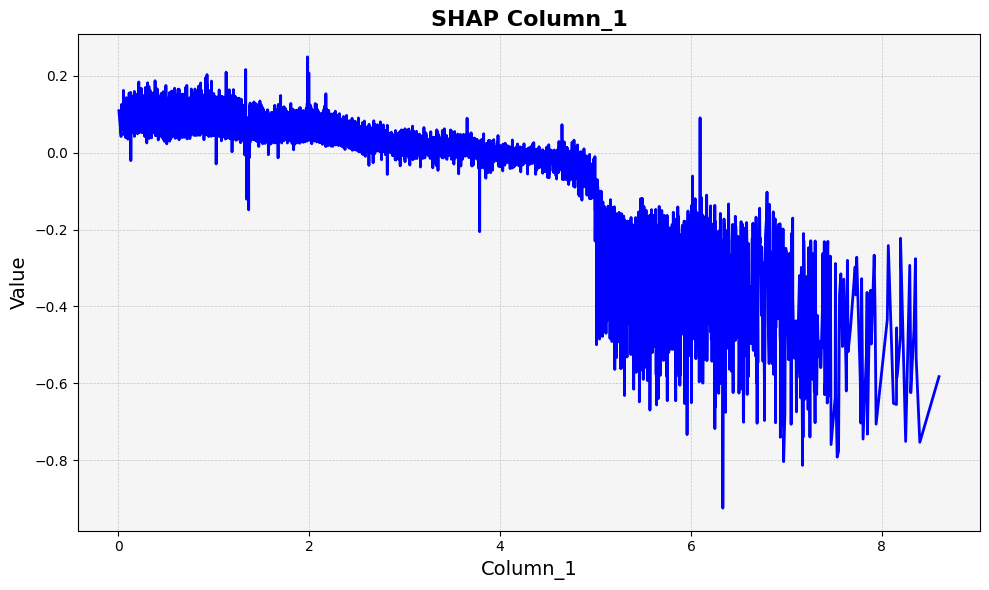

In [5]:
# Feature 1 Analysis
feature_df_1 = explainer.analyze_feature(1)
plot_line_chart(
    x=feature_1,
    y=-0.6 * transformed_1
    + 0.6 * interaction_0_1
    - np.mean(-0.6 * transformed_1 + 0.6 * interaction_0_1),
    x_label="Column_1",
    y_label="Value",
    title="-0.6 * transformed_1 + 0.6 * interaction_0_1 - E[1]",
)
feature_plot(
    feature_df_1, show_min_max=False, col_min=X[:, 1].min(), col_max=X[:, 1].max()
)
plot_line_chart(
    x=feature_1,
    y=shap_values.values[:, 1],
    x_label="Column_1",
    y_label="Value",
    title="SHAP Column_1",
)

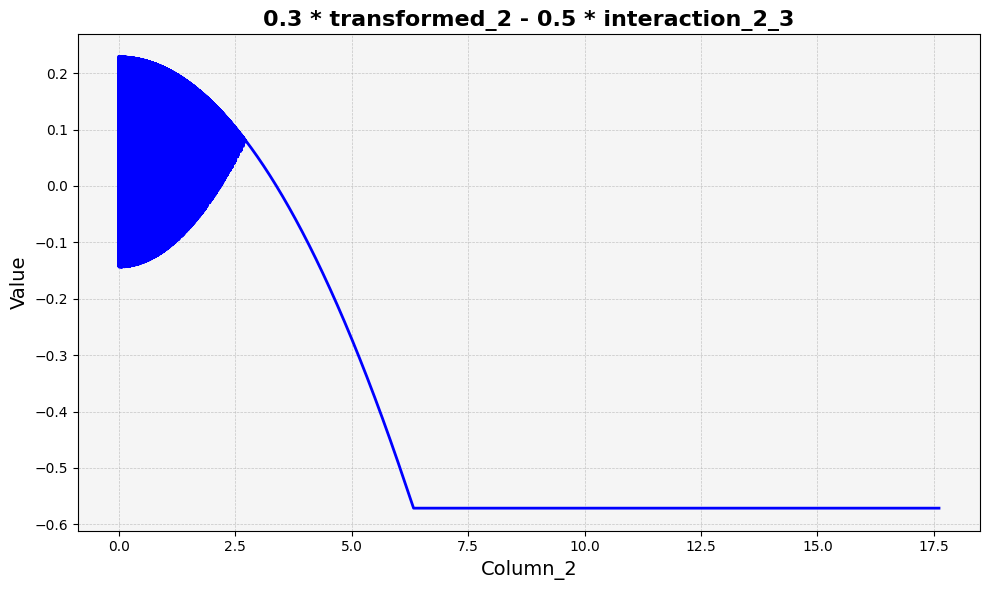

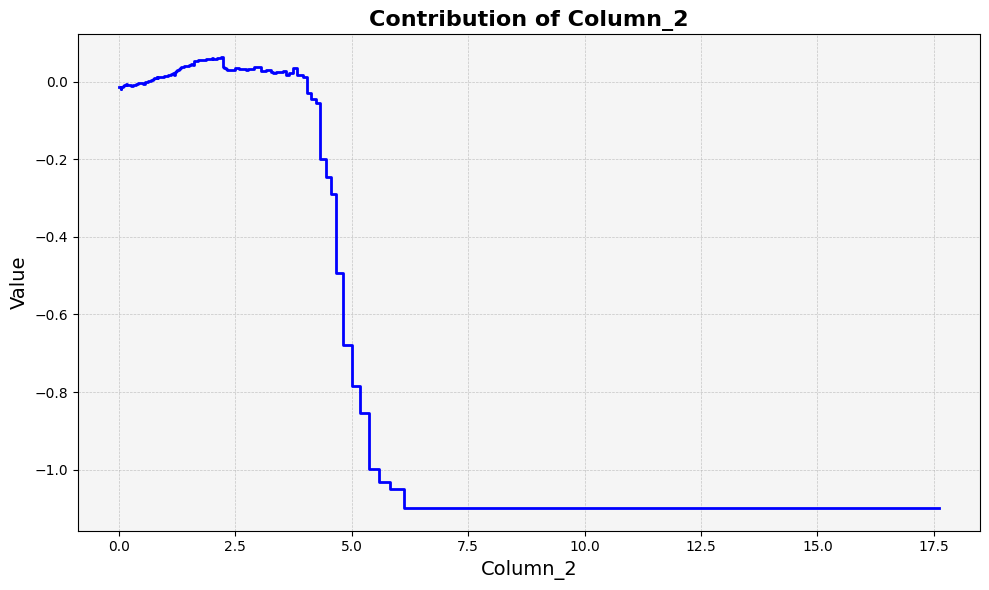

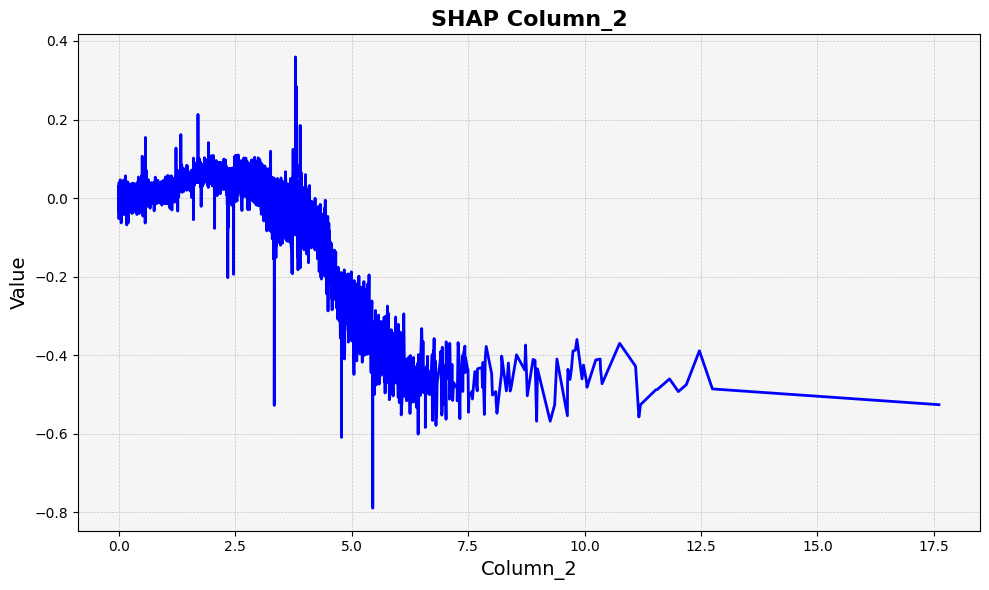

In [6]:
# Feature 2 Analysis
feature_df_2 = explainer.analyze_feature(2)
plot_line_chart(
    x=feature_2,
    y=0.3 * transformed_2
    - 0.5 * interaction_2_3
    - np.mean(0.3 * transformed_2 - 0.5 * interaction_2_3),
    x_label="Column_2",
    y_label="Value",
    title="0.3 * transformed_2 - 0.5 * interaction_2_3",
)
feature_plot(
    feature_df_2, show_min_max=False, col_min=X[:, 2].min(), col_max=X[:, 2].max()
)
plot_line_chart(
    x=feature_2,
    y=shap_values.values[:, 2],
    x_label="Column_2",
    y_label="Value",
    title="SHAP Column_2",
)

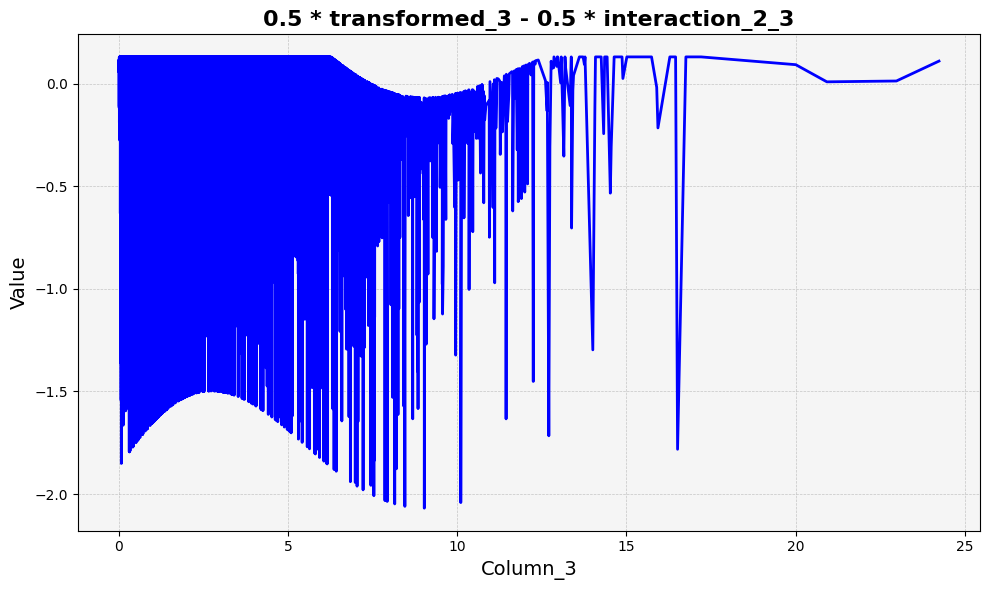

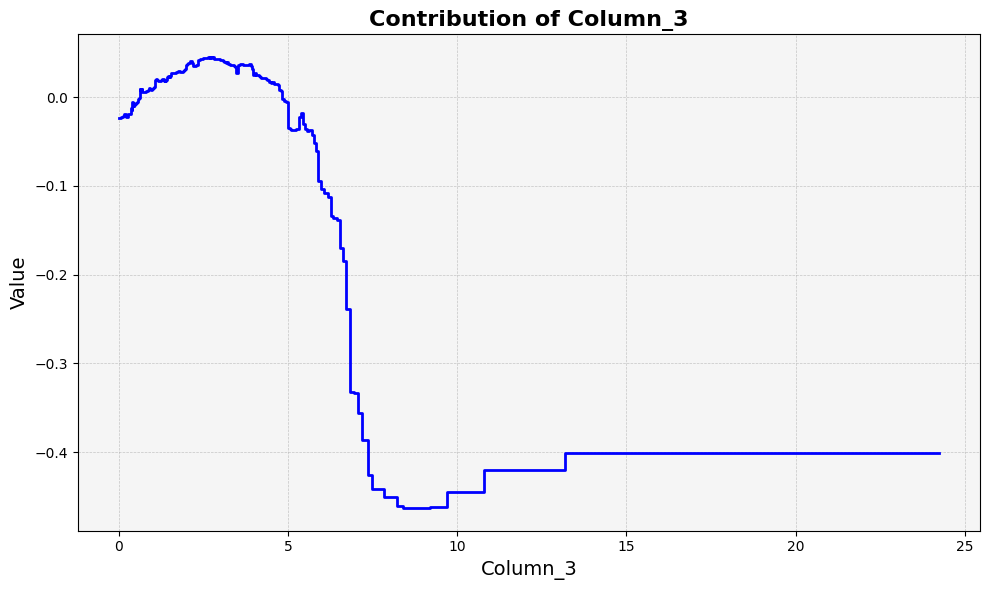

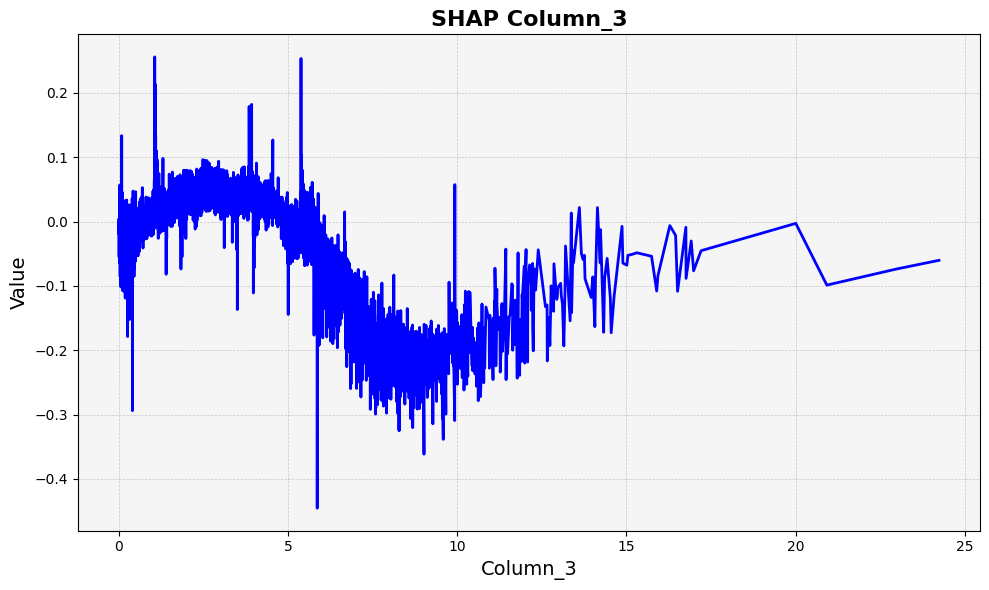

In [7]:
# Feature 3 Analysis
feature_df_3 = explainer.analyze_feature(3)
plot_line_chart(
    x=feature_3,
    y=0.5 * transformed_3
    - 0.5 * interaction_2_3
    - np.mean(0.5 * transformed_3 - 0.5 * interaction_2_3),
    x_label="Column_3",
    y_label="Value",
    title="0.5 * transformed_3 - 0.5 * interaction_2_3",
)
feature_plot(
    feature_df_3, show_min_max=False, col_min=X[:, 3].min(), col_max=X[:, 3].max()
)
plot_line_chart(
    x=feature_3,
    y=shap_values.values[:, 3],
    x_label="Column_3",
    y_label="Value",
    title="SHAP Column_3",
)

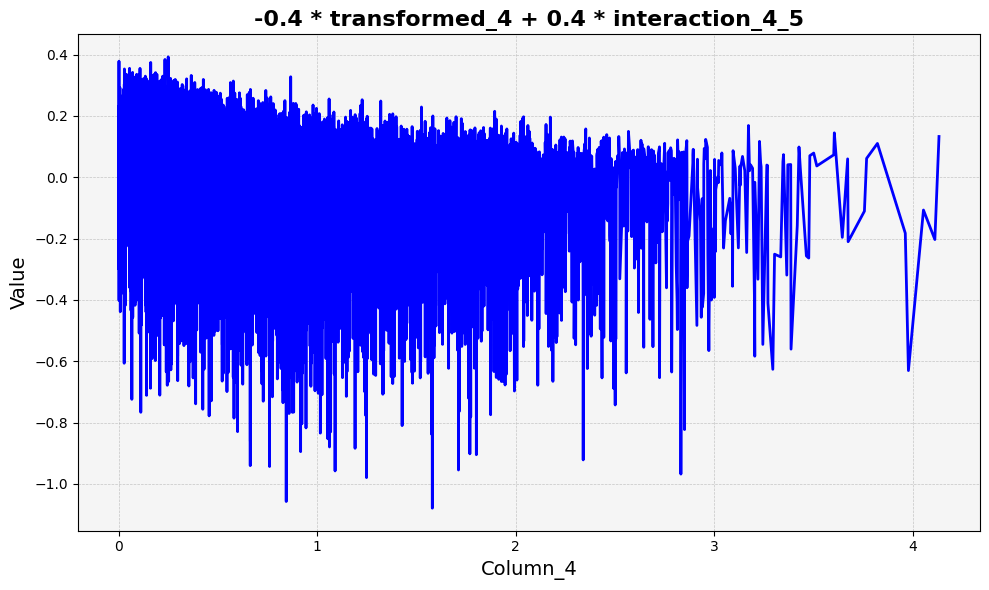

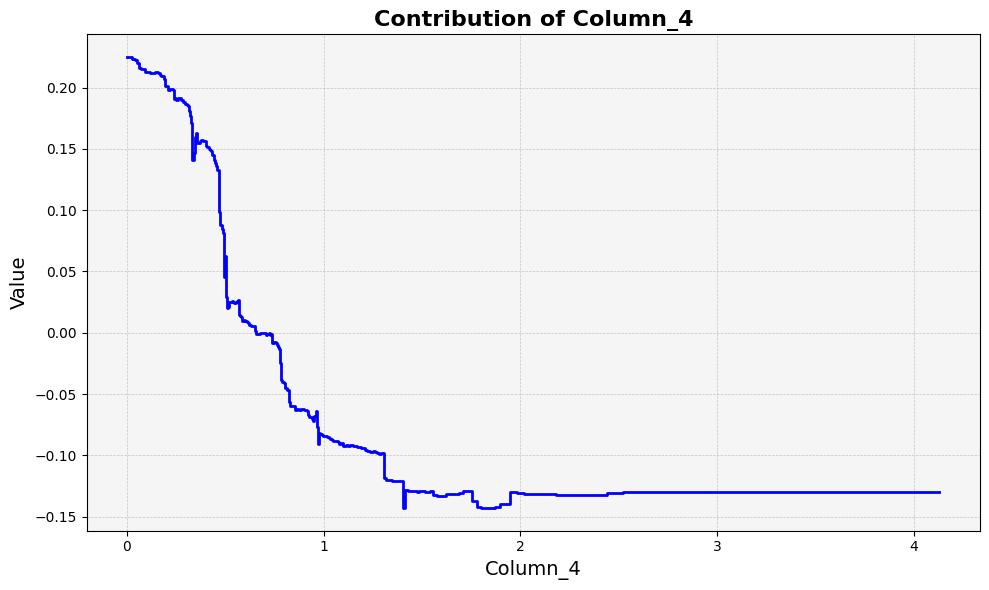

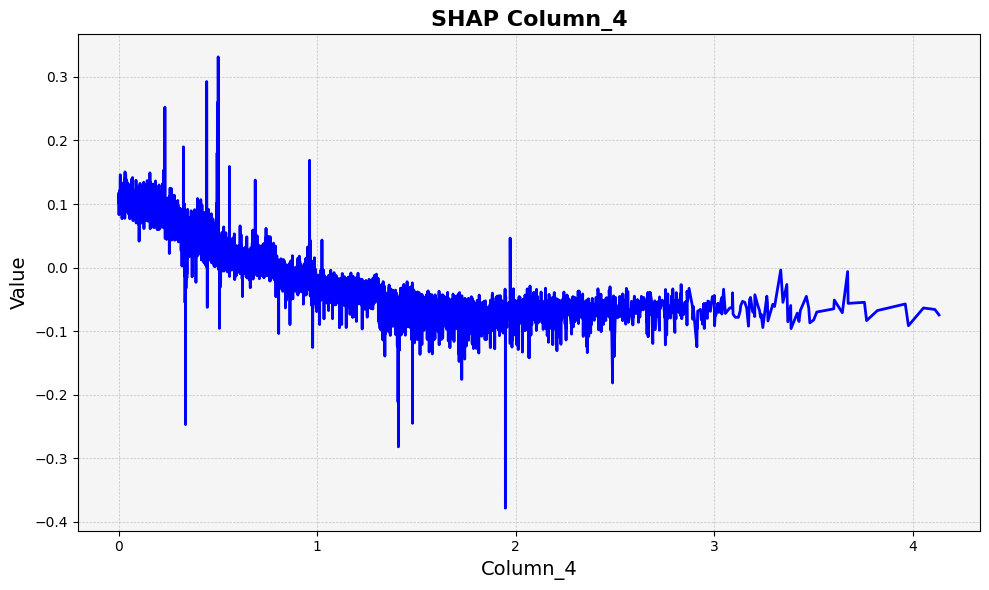

In [8]:
# Feature 4 Analysis
feature_df_4 = explainer.analyze_feature(4)
plot_line_chart(
    x=feature_4,
    y=-0.4 * transformed_4
    + 0.4 * interaction_4_5
    - np.mean(-0.4 * transformed_4 + 0.4 * interaction_4_5),
    x_label="Column_4",
    y_label="Value",
    title="-0.4 * transformed_4 + 0.4 * interaction_4_5",
)
feature_plot(
    feature_df_4, show_min_max=False, col_min=X[:, 4].min(), col_max=X[:, 4].max()
)
plot_line_chart(
    x=feature_4,
    y=shap_values.values[:, 4],
    x_label="Column_4",
    y_label="Value",
    title="SHAP Column_4",
)

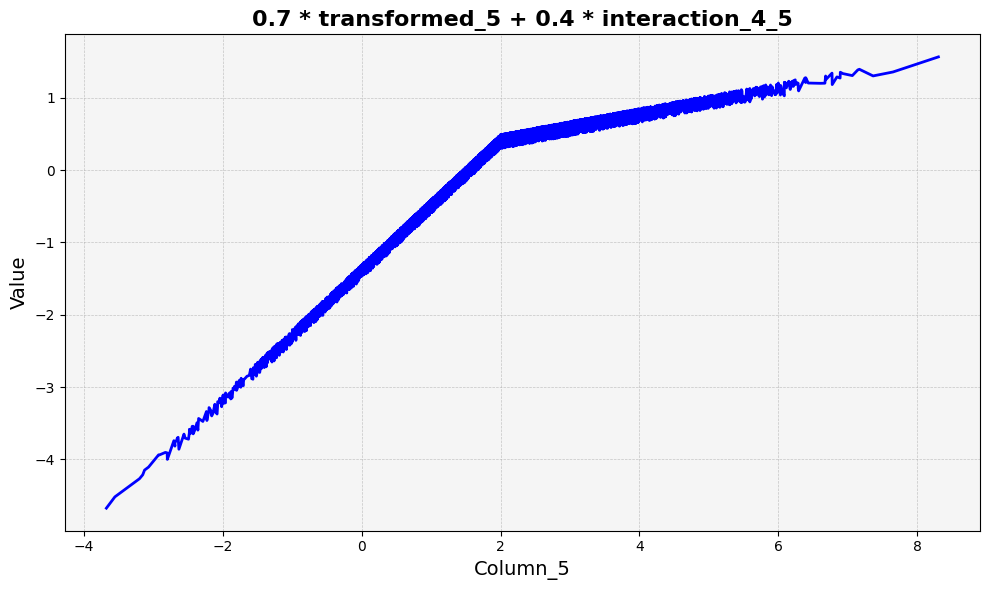

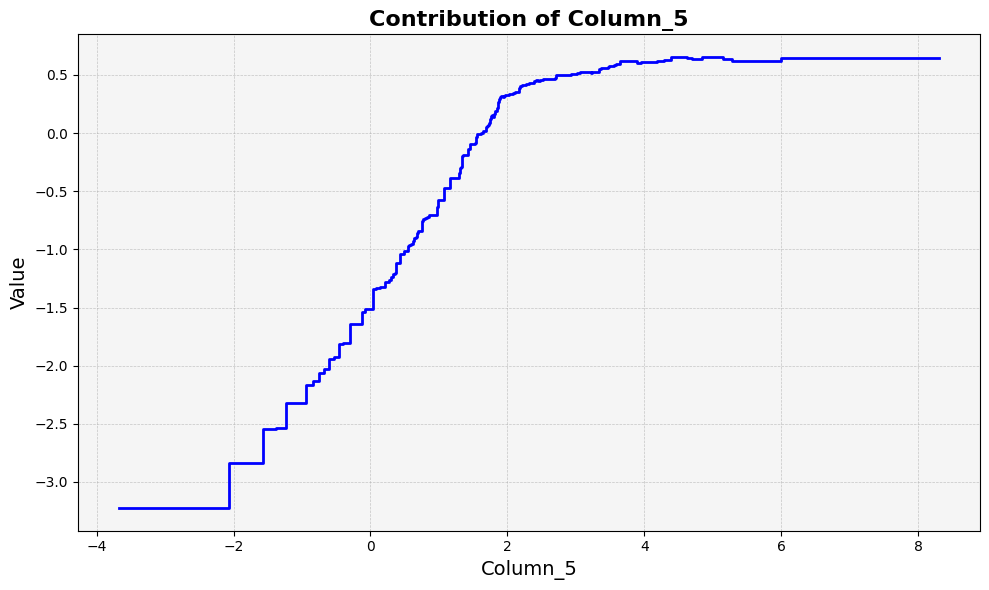

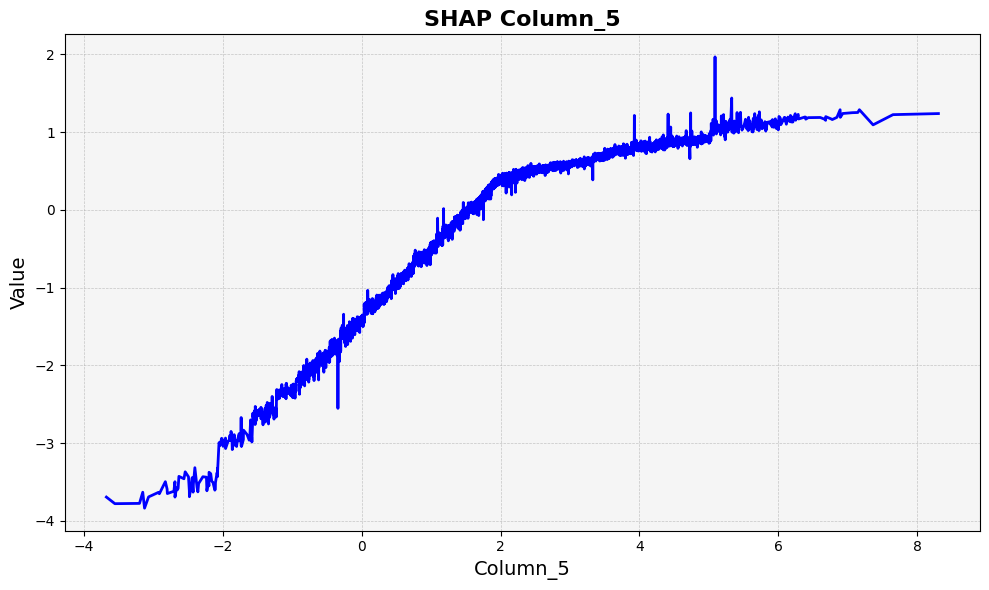

In [9]:
# Feature 5 Analysis
feature_df_5 = explainer.analyze_feature(5)
plot_line_chart(
    x=feature_5,
    y=0.7 * transformed_5
    + 0.4 * interaction_4_5
    - np.mean(0.7 * transformed_5 + 0.4 * interaction_4_5),
    x_label="Column_5",
    y_label="Value",
    title="0.7 * transformed_5 + 0.4 * interaction_4_5",
)
feature_plot(
    feature_df_5, show_min_max=False, col_min=X[:, 5].min(), col_max=X[:, 5].max()
)
plot_line_chart(
    x=feature_5,
    y=shap_values.values[:, 5],
    x_label="Column_5",
    y_label="Value",
    title="SHAP Column_5",
)

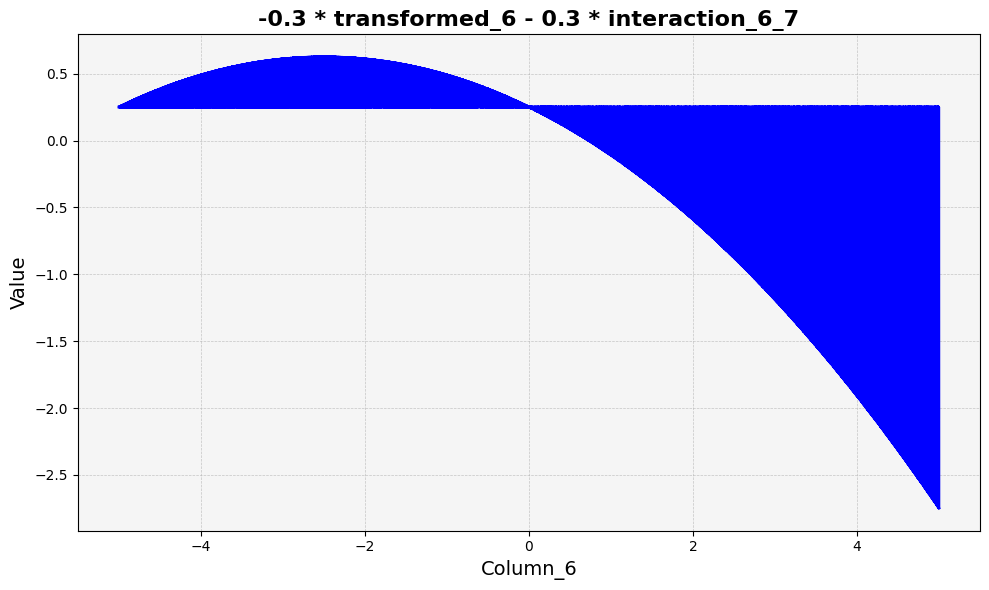

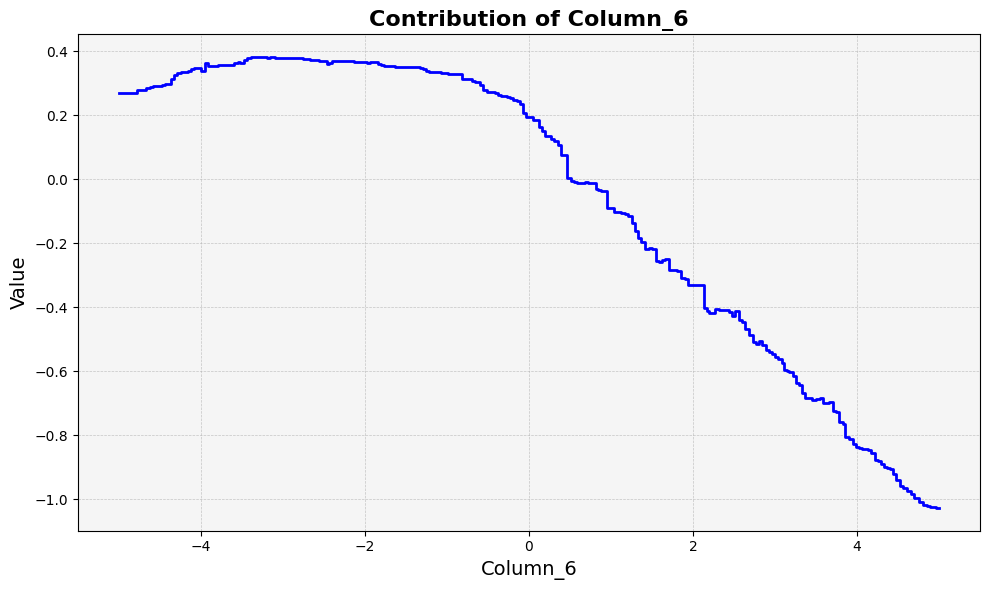

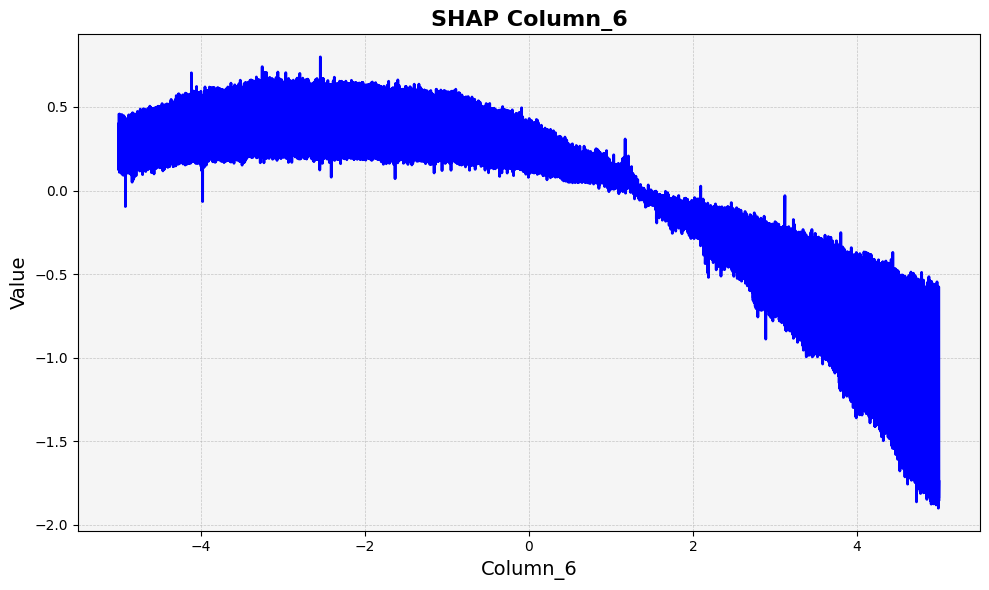

In [10]:
# Feature 6 Analysis
feature_df_6 = explainer.analyze_feature(6)
plot_line_chart(
    x=feature_6,
    y=-0.3 * transformed_6
    - 0.3 * interaction_6_7
    - np.mean(-0.3 * transformed_6 - 0.3 * interaction_6_7),
    x_label="Column_6",
    y_label="Value",
    title="-0.3 * transformed_6 - 0.3 * interaction_6_7",
)
feature_plot(
    feature_df_6, show_min_max=False, col_min=X[:, 6].min(), col_max=X[:, 6].max()
)
plot_line_chart(
    x=feature_6,
    y=shap_values.values[:, 6],
    x_label="Column_6",
    y_label="Value",
    title="SHAP Column_6",
)

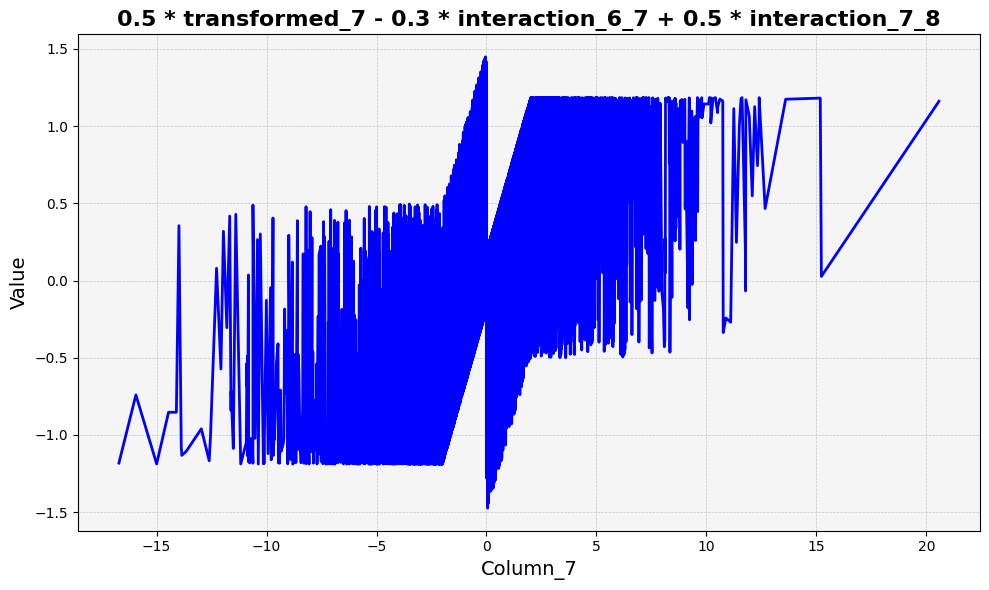

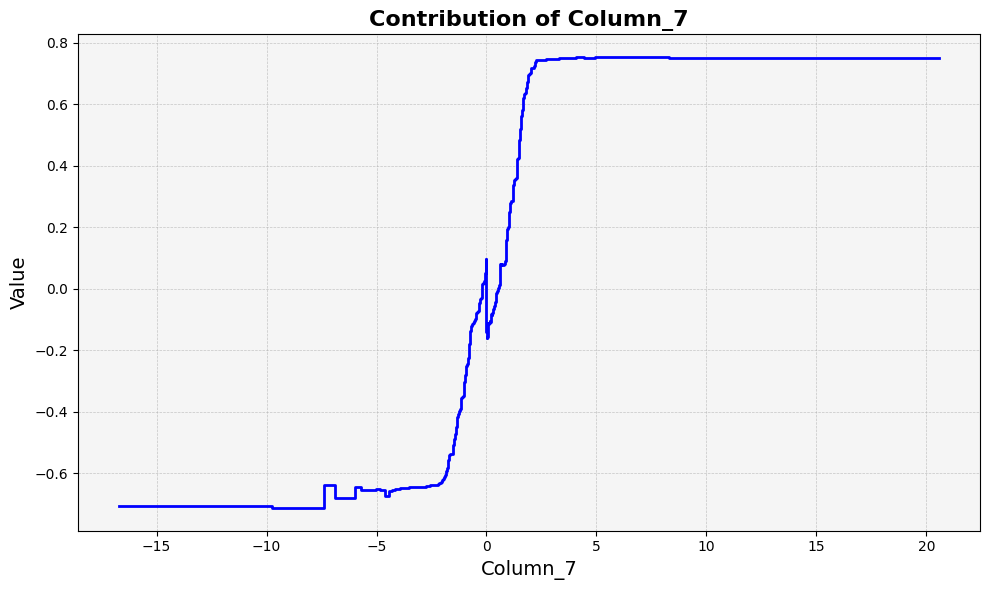

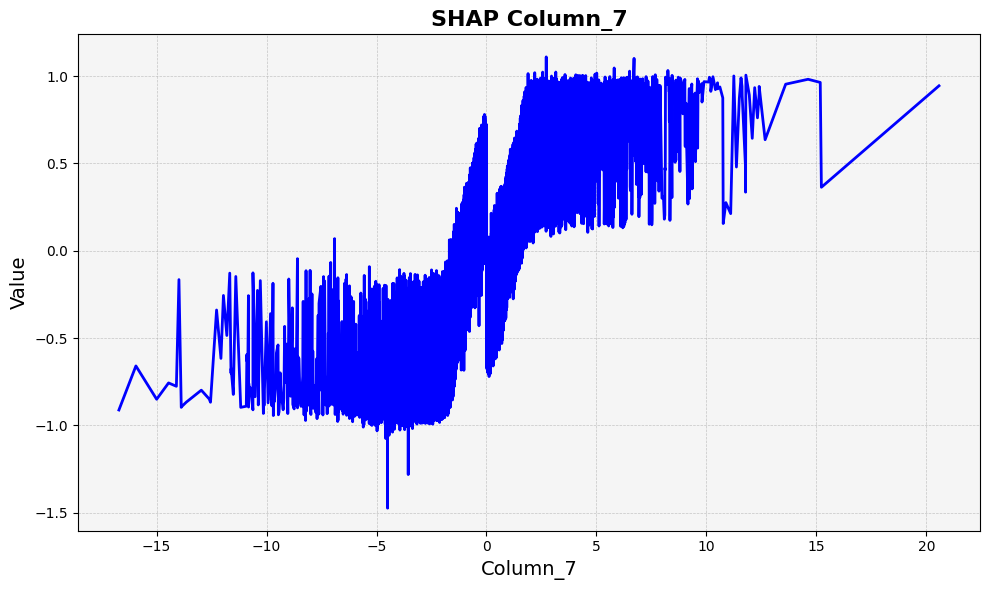

In [11]:
# Feature 7 Analysis
feature_df_7 = explainer.analyze_feature(7)
plot_line_chart(
    x=feature_7,
    y=0.5 * transformed_7
    - 0.3 * interaction_6_7
    + 0.5
    - np.mean(0.5 * transformed_7 - 0.3 * interaction_6_7 + 0.5),
    x_label="Column_7",
    y_label="Value",
    title="0.5 * transformed_7 - 0.3 * interaction_6_7 + 0.5 * interaction_7_8",
)
feature_plot(
    feature_df_7, show_min_max=False, col_min=X[:, 7].min(), col_max=X[:, 7].max()
)
plot_line_chart(
    x=feature_7,
    y=shap_values.values[:, 7],
    x_label="Column_7",
    y_label="Value",
    title="SHAP Column_7",
)

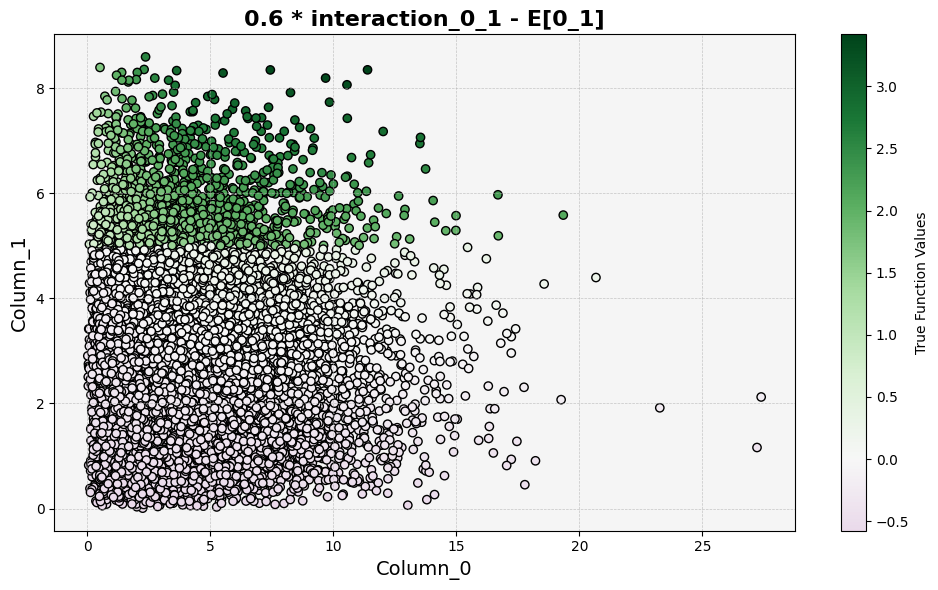

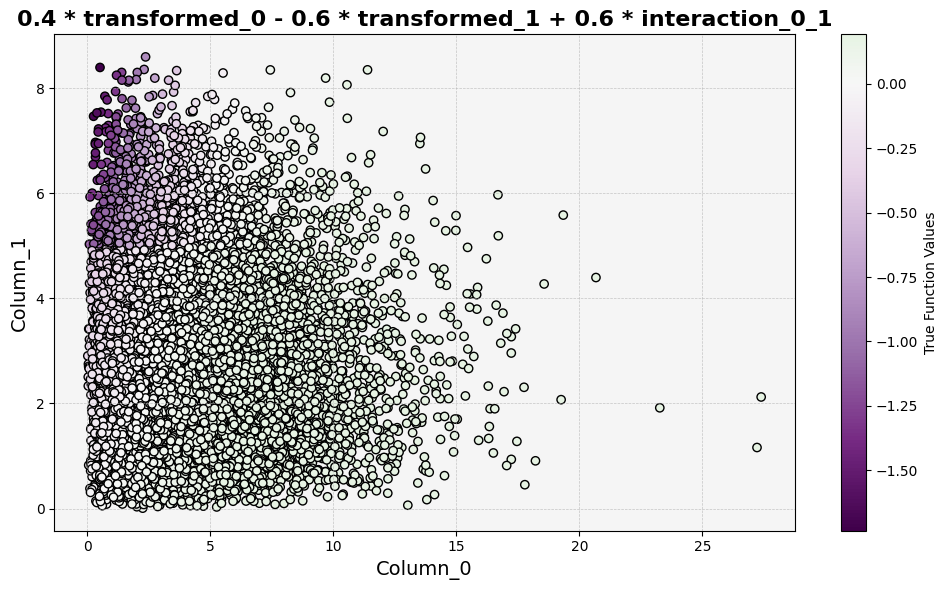

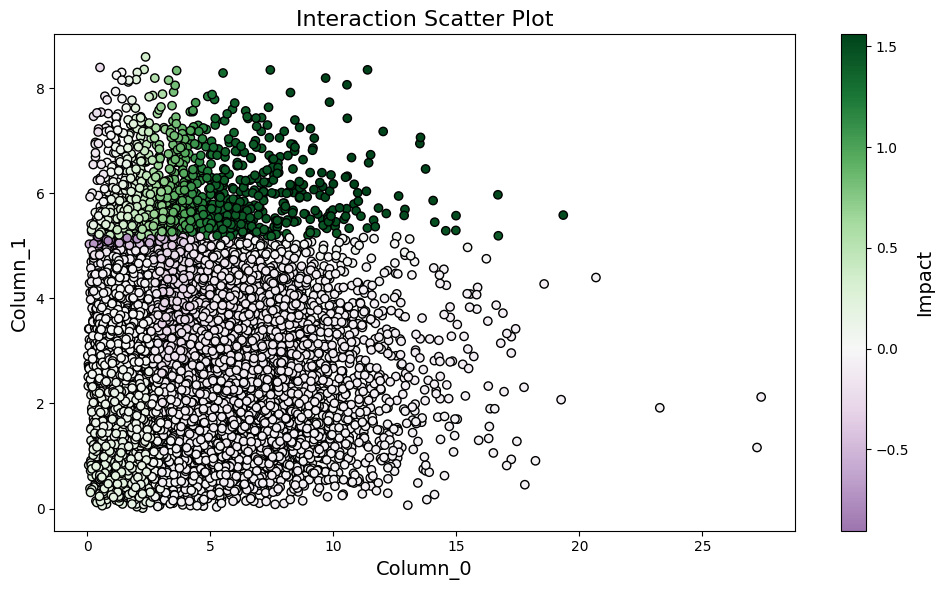

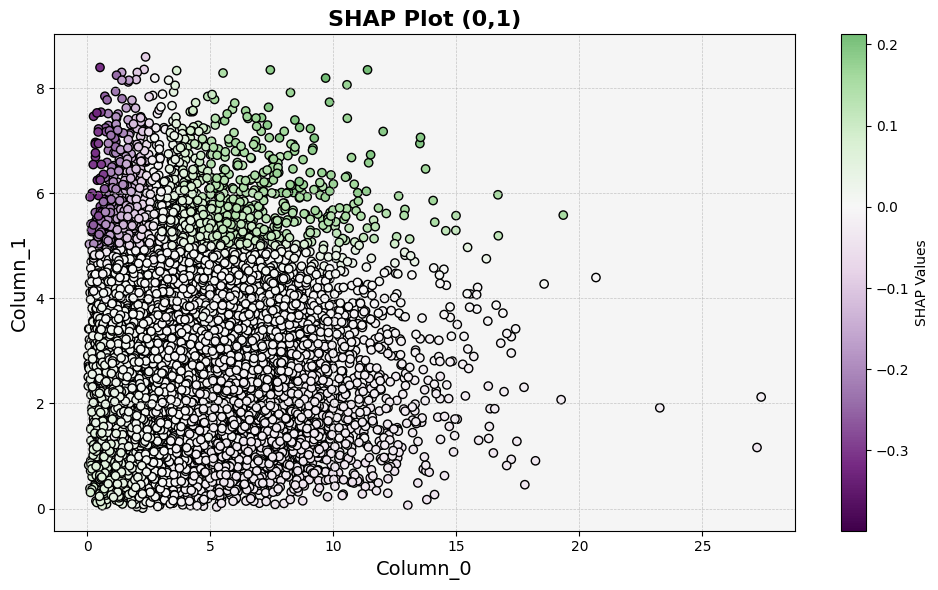

In [12]:
# Interaction Analysis: Feature 0 & Feature 1
df_01 = explainer.analyze_interaction(0, 1)

plot_scatter_chart(
    feature_0,
    feature_1,
    0.6 * interaction_0_1 - np.mean(0.6 * interaction_0_1),
    x_label="Column_0",
    y_label="Column_1",
    title="0.6 * interaction_0_1 - E[0_1]",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_0,
    feature_1,
    0.4 * transformed_0
    - 0.6 * transformed_1
    + 0.6 * interaction_0_1
    - np.mean(0.4 * transformed_0 - 0.6 * transformed_1 + 0.6 * interaction_0_1),
    x_label="Column_0",
    y_label="Column_1",
    title="0.4 * transformed_0 - 0.6 * transformed_1 + 0.6 * interaction_0_1",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_01, 0, 1, figsize=(10, 6))

plot_scatter_chart(
    feature_0,
    feature_1,
    shap_interaction_values[:, 0, 1],
    x_label="Column_0",
    y_label="Column_1",
    title="SHAP Plot (0,1)",
    cbar_label="SHAP Values",
)

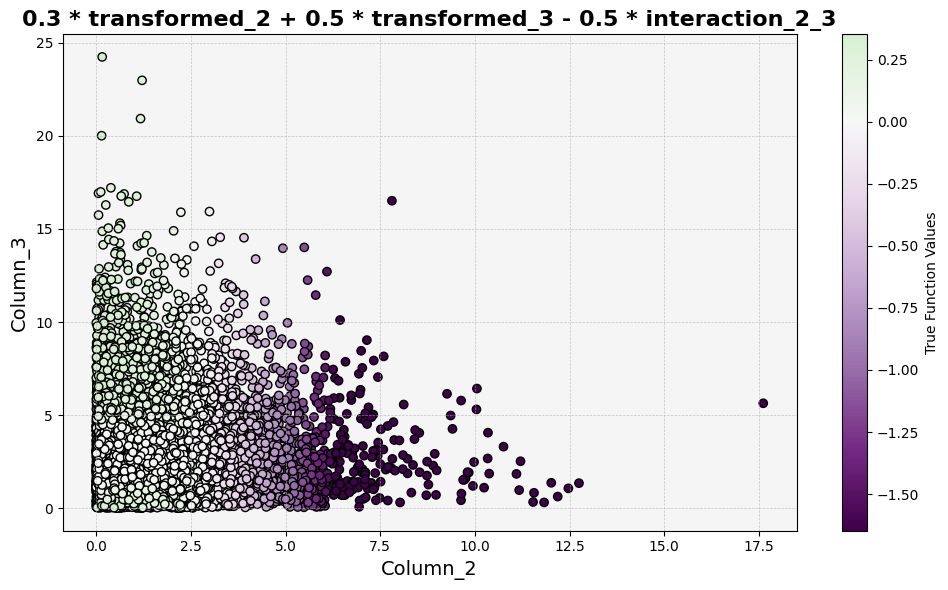

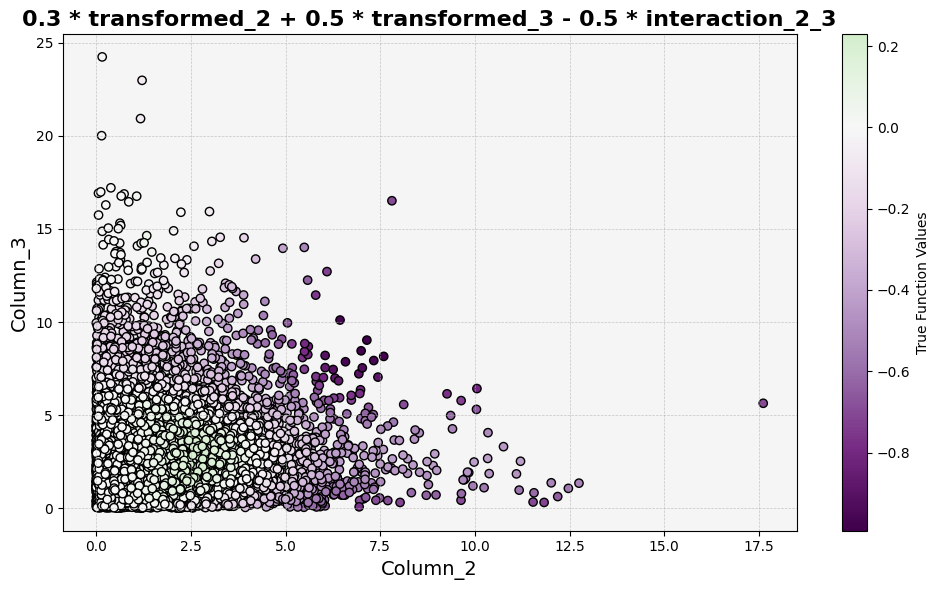

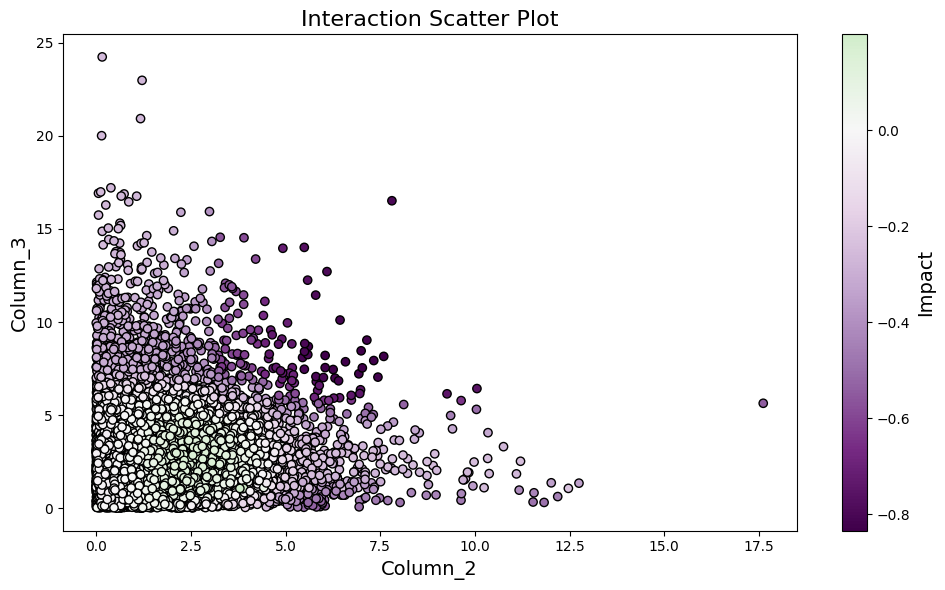

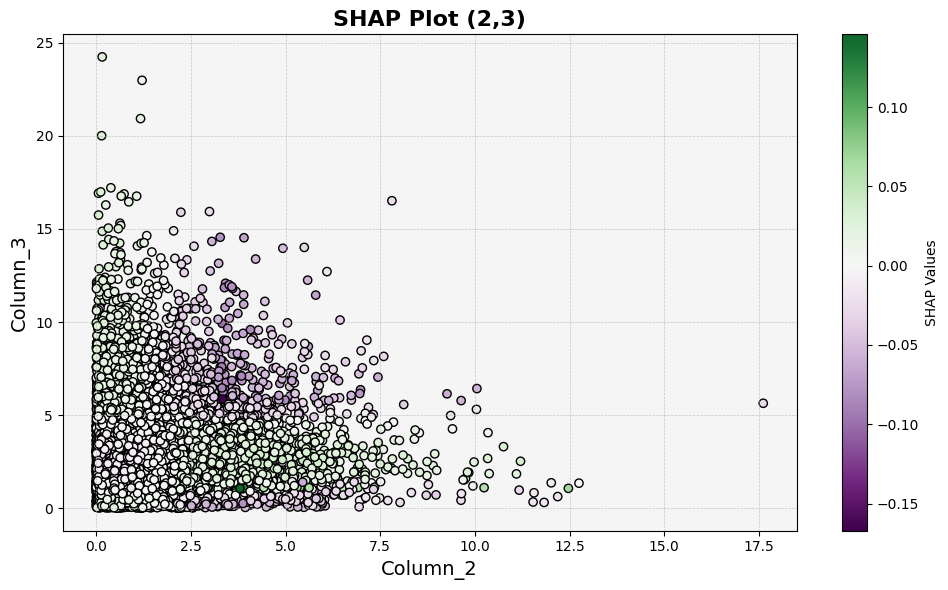

In [13]:
# Interaction Analysis: Feature 2 & Feature 3
df_23 = explainer.analyze_interaction(2, 3)
plot_scatter_chart(
    feature_2,
    feature_3,
    -0.5 * interaction_2_3 - np.mean(-0.5 * interaction_2_3),
    x_label="Column_2",
    y_label="Column_3",
    title="0.3 * transformed_2 + 0.5 * transformed_3 - 0.5 * interaction_2_3",
    cbar_label="True Function Values",
)
plot_scatter_chart(
    feature_2,
    feature_3,
    0.3 * transformed_2
    + 0.5 * transformed_3
    - 0.5 * interaction_2_3
    - np.mean(0.3 * transformed_2 + 0.5 * transformed_3 - 0.5 * interaction_2_3),
    x_label="Column_2",
    y_label="Column_3",
    title="0.3 * transformed_2 + 0.5 * transformed_3 - 0.5 * interaction_2_3",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_23, 2, 3, figsize=(10, 6))

plot_scatter_chart(
    feature_2,
    feature_3,
    shap_interaction_values[:, 2, 3],
    x_label="Column_2",
    y_label="Column_3",
    title="SHAP Plot (2,3)",
    cbar_label="SHAP Values",
)

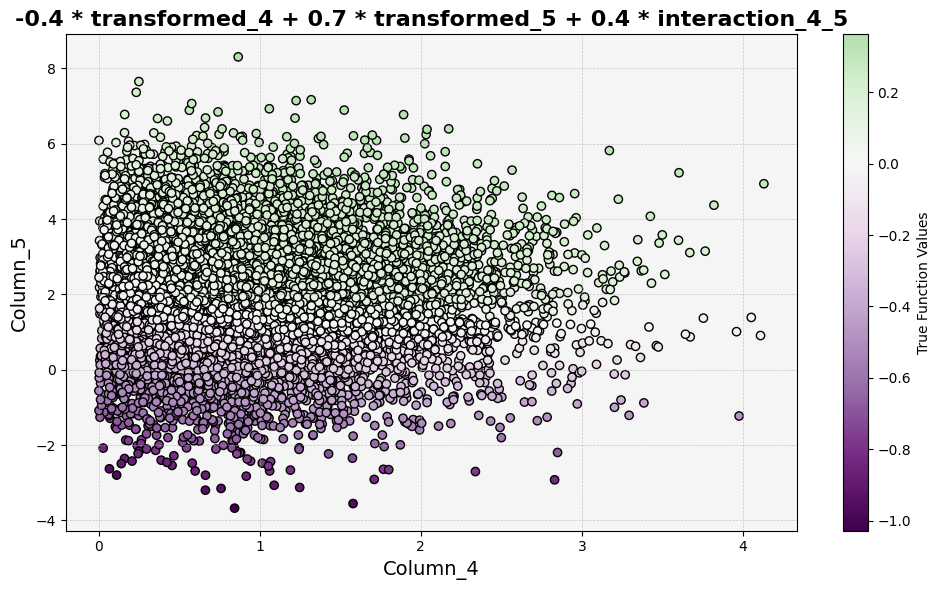

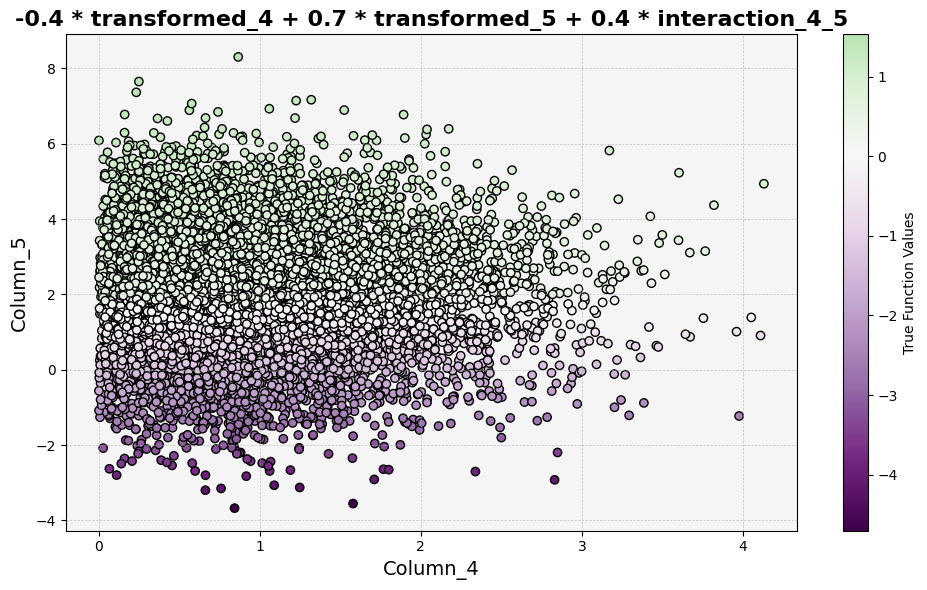

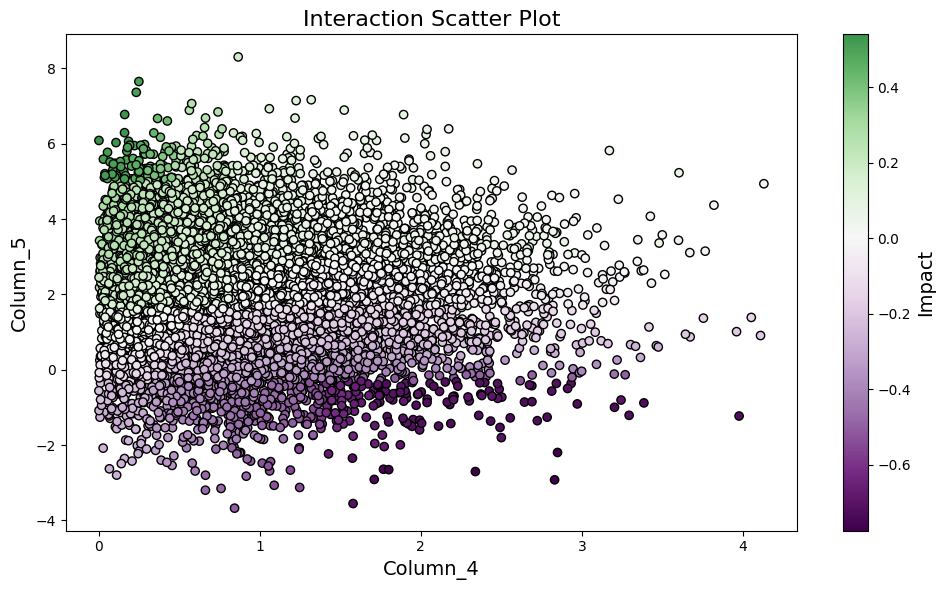

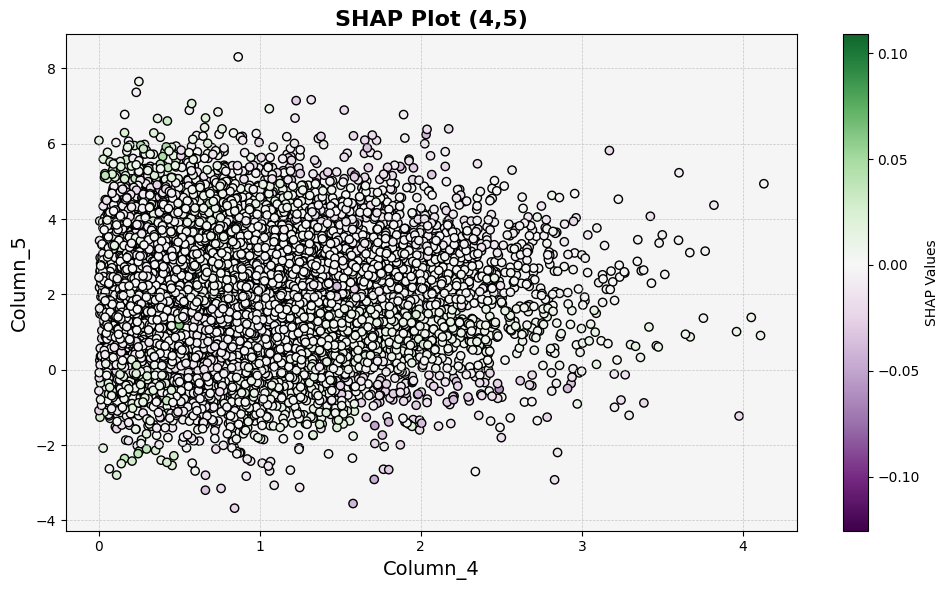

In [14]:
# Interaction Analysis: Feature 4 & Feature 5
df_45 = explainer.analyze_interaction(4, 5)

plot_scatter_chart(
    feature_4,
    feature_5,
    0.4 * interaction_4_5 - np.mean(0.4 * interaction_4_5),
    x_label="Column_4",
    y_label="Column_5",
    title="-0.4 * transformed_4 + 0.7 * transformed_5 + 0.4 * interaction_4_5",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_4,
    feature_5,
    -0.4 * transformed_4
    + 0.7 * transformed_5
    + 0.4 * interaction_4_5
    - np.mean(-0.4 * transformed_4 + 0.7 * transformed_5 + 0.4 * interaction_4_5),
    x_label="Column_4",
    y_label="Column_5",
    title="-0.4 * transformed_4 + 0.7 * transformed_5 + 0.4 * interaction_4_5",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_45, 4, 5, figsize=(10, 6))

plot_scatter_chart(
    feature_4,
    feature_5,
    shap_interaction_values[:, 4, 5],
    x_label="Column_4",
    y_label="Column_5",
    title="SHAP Plot (4,5)",
    cbar_label="SHAP Values",
)

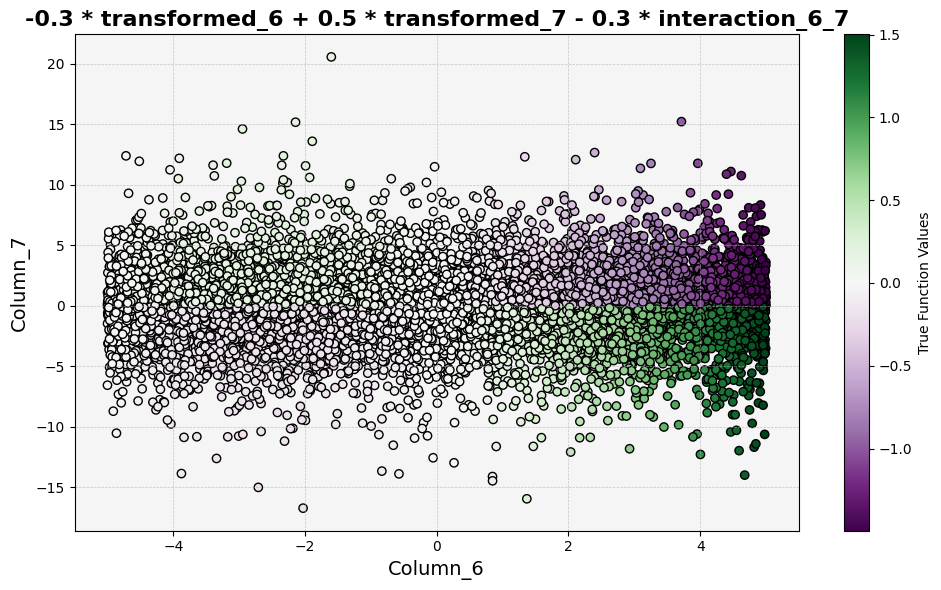

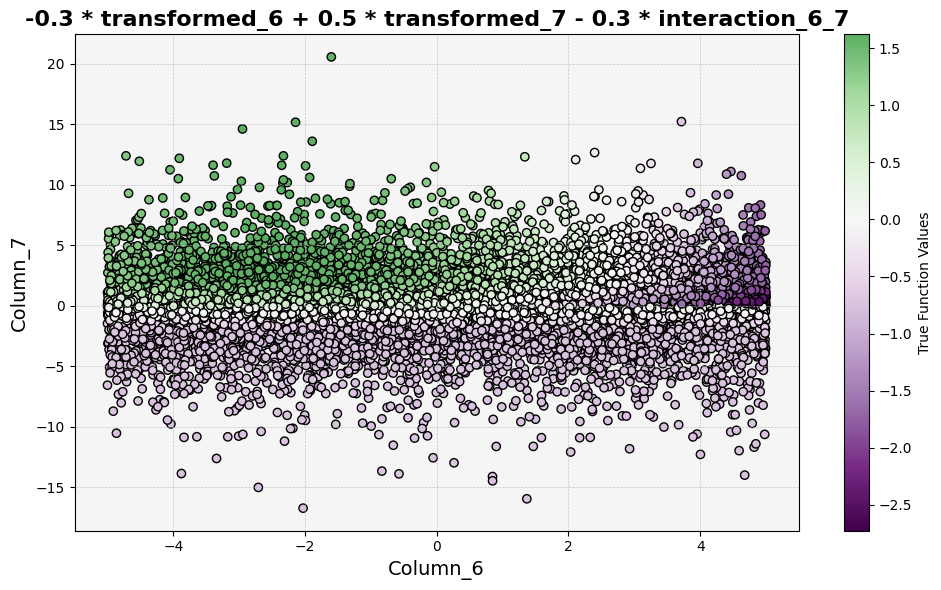

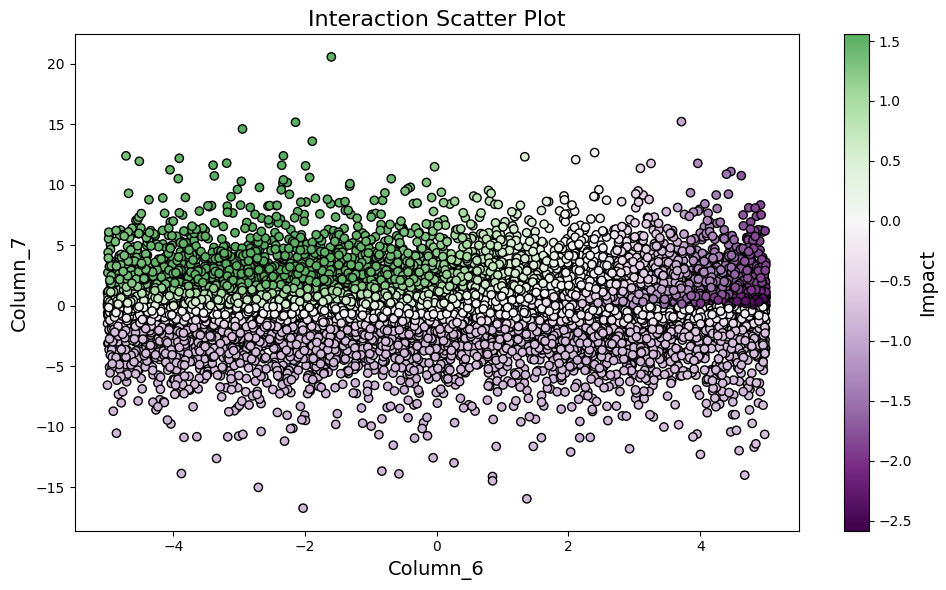

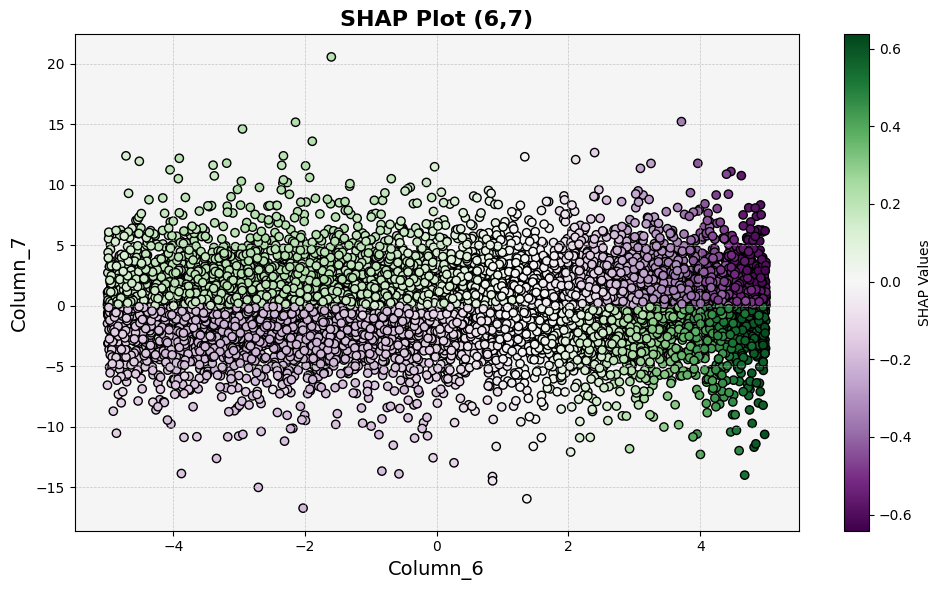

In [15]:
# Interaction Analysis: Feature 6 & Feature 7
df_67 = explainer.analyze_interaction(6, 7)

plot_scatter_chart(
    feature_6,
    feature_7,
    -0.3 * interaction_6_7 - np.mean(-0.3 * interaction_6_7),
    x_label="Column_6",
    y_label="Column_7",
    title="-0.3 * transformed_6 + 0.5 * transformed_7 - 0.3 * interaction_6_7",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_6,
    feature_7,
    -0.3 * transformed_6
    + 0.5 * transformed_7
    - 0.3 * interaction_6_7
    - np.mean(-0.3 * transformed_6 + 0.5 * transformed_7 - 0.3 * interaction_6_7),
    x_label="Column_6",
    y_label="Column_7",
    title="-0.3 * transformed_6 + 0.5 * transformed_7 - 0.3 * interaction_6_7",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_67, 6, 7, figsize=(10, 6))

plot_scatter_chart(
    feature_6,
    feature_7,
    shap_interaction_values[:, 6, 7],
    x_label="Column_6",
    y_label="Column_7",
    title="SHAP Plot (6,7)",
    cbar_label="SHAP Values",
)